# Simulación del proceso de vacunación en los recintos electorales

### Recinto electoral: UNIDAD EDUCATIVA SALESIANAS MARIA AUXILIADORA 
- Número de personas que asistieron a votar en este recinto: 12000
- Número de mesas: 20 mujeres y 20 hombres.

### Regresión para la vacuna

In [3]:
import pandas as pd
from datetime import datetime

fabricantes=pd.read_csv('fabricantes.csv')
FMT = '%d/%m/%Y'
fabricantes['arrived_at'] = fabricantes['arrived_at'].map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("01/01/2021", FMT)).days)

fabricantes=fabricantes[['arrived_at','total']]
fabricantes

x = fabricantes.iloc[:, :-1].values  
y = fabricantes.iloc[:, 1].values

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) 

from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
b=regressor.intercept_
m=regressor.coef_

#Regresion Lineal
y_pred = regressor.predict(X_test)  
df1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}) 
df1

Actual      Predicted
0    8190  -50355.020008
1   16380   23080.340313
2   65520  114874.540714
3   73710   78156.860553

# Predicción de la llegada de vacunas para un día específico.

In [5]:
prediccionDiaFabricantes = "16/05/2021"
date_string = prediccionDiaFabricantes
FMT = '%d/%m/%Y'
nuevaFecha =  (datetime.strptime(date_string, FMT) - datetime.strptime("01/01/2021", FMT)).days
y_pred1 = regressor.predict([[nuevaFecha]])

predFab = pd.DataFrame({date_string: [round(y_pred1[0])]}) 
predFab

16/05/2021
0      253877

### Simulación de la Vacunación haciendo uso de Simpy

- La simulación tiene el número de mesas/puestos de vacunación existentes en el recinto electoral.
- Luego se definen los tiempos de los intervalos de tiempo que toman los diferentes procesos.
- La clase vacunación contiene los valores de los intervalos y ademas contiene funciones que simulan el proceso en el que el usuario realiza una actividad que toma un determinado tiempo.

- Se lleva el registro de las personas que fueron vacunadas y las que no.
- Por cada persona se toma el tiempo en el que realiza todo el proceso y también el tiempo solamente de la vacunación. Estos datos son almacenados en un diccionario para realizar las gráficas.

- Para iniciar llegan 40 personas para los 40 puestos de vacunación existentes, y ocupan un recurso. Las nuevas personas que lleguen no podrá ser vacunadas hasta que un puesto se encuentre vacío. Y desde ahí a cada minuto llegará una persona mas a hacer fila en alguno de los puestos.

## Simulación de 1 día - Primera dosis

In [91]:
import simpy
import random
import matplotlib.pyplot as pp

from datetime import date, timedelta

# Personas que asistieron a votar
TOTAL_PERSONAS = 12000
# Personal de vacunación
MESAS = 40

# Intervalo de tiempo en el que llegan las personas (minutos)
INTERVALO_LLEGADA = 20
# Intervalo de control de una persona 1 minuto para el registro de los datos
INTERVALO_MESA = 1
# Intervalo vacunación entre 5-10 minutos
INTERVALO_VACUNACION = 8
# Intervalo de tiempo en el que una persona debe esperar para verificar que no tenga problemas de salud.
INTERVALO_POST_VACUNACION = 20

# Tiempo de simulación 2H
TIEMPO_SIMULACION = 480
# Cantidad de vacunados
CANTIDAD_VACUNADOS = 0
# Cantidad de personas que llegaron
CANTIDAD_PERSONAS = 0
# Tiempo Vacunación
TIEMPOVACUNACION = 0
# Tiempo Espera
TIEMPOESPERA = 0
# Tiempo de vacunación de cada persona para la primera dosis
TIEMPOVACUNACIONDICT1 = {}
# Tiempo de espera de cada persona para la primera dosis
TIEMPOESPERADICT1 = {}

# Tiempo de vacunación de cada persona para la segunda dosis
TIEMPOVACUNACIONDICT2 = {}
# Tiempo de espera de cada persona para la segunda dosis
TIEMPOESPERADICT2 = {}


class Vacunacion(object):

    def __init__(self, environment, cantMesa, tiempoMesa, tiempoVacunacion, tiempoPostVacunacion):
        self.env = environment
        #Creamos los puestos de vacunación
        self.mesas = simpy.Resource(environment, cantMesa)
        self.tiempoMesa = tiempoMesa
        self.tiempoVacunacion = tiempoVacunacion
        self.tiempoPostVacunacion = tiempoPostVacunacion

    def esperarMesa(self):
        yield self.env.timeout(self.tiempoMesa)
        
    def vacunar_persona(self, persona):
        yield self.env.timeout(random.randint(self.tiempoVacunacion-3, self.tiempoVacunacion+2))
        
    def esperarPostVacuna(self):
        yield self.env.timeout(self.tiempoPostVacunacion)
        
    def recibirCertificado(self):
        yield self.env.timeout(random.randint(2,3))
        
def conteoVacunados():
    global CANTIDAD_VACUNADOS
    CANTIDAD_VACUNADOS +=1

def conteoPersonas():
    global CANTIDAD_PERSONAS
    CANTIDAD_PERSONAS +=1
    
def tiempoEspera(persona, tiempoEspera, dosis):
    if(dosis == 1):
        global TIEMPOESPERA
        global TIEMPOESPERADICT1
        # Agregamos al diccionario el tiempo de espera por persona
        TIEMPOESPERADICT1[int(persona.split('-')[1])] = tiempoEspera
        # Se obtiene el tiempo total de espera de todas las personas
        TIEMPOESPERA += tiempoEspera
    else :
        global TIEMPOESPERADICT2
        # Agregamos al diccionario el tiempo de espera por persona
        TIEMPOESPERADICT2[int(persona.split('-')[1])] = tiempoEspera
        # Se obtiene el tiempo total de espera de todas las personas
        TIEMPOESPERA += tiempoEspera
    
def tiempoVacunacion(persona, tiempoPersona, dosis):
    if(dosis == 1):
        global TIEMPOVACUNACION 
        global TIEMPOVACUNACIONDICT1
        # Agregamos al diccionario el tiempo de vacunación por persona
        TIEMPOVACUNACIONDICT1[int(persona.split('-')[1])] = tiempoPersona
        # Se obtiene el tiempo total de vacunación de todas las personas
        TIEMPOVACUNACION += tiempoPersona
    else: 
        global TIEMPOVACUNACIONDICT2
        # Agregamos al diccionario el tiempo de vacunación por persona
        TIEMPOVACUNACIONDICT2[int(persona.split('-')[1])] = tiempoPersona
        # Se obtiene el tiempo total de vacunación de todas las personas
        TIEMPOVACUNACION += tiempoPersona
    

def llegada_persona(env, personaId, vacunacion, dosis):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega una persona con el nombre pasado como parametro
    print('→ [%s] llega al recinto a la hora %.2f.' % (personaId, env.now))
    
    # La persona llega a la mesa y hace fila si la mesa no esta libre
    yield env.process(vacunacion.esperarMesa())
    
    # Inicio del proceso total de vacunación y control
    inicioEspera = env.now
        
    # Se cumple con que entre el 5% - 10% de las personas no cumplen con las condiciones para ser vacunadas.
    rnd = random.randint(1,100)
    if rnd <= 10:
        print('La persona [%s] no puede ser vacunada'%(personaId))
    else:
        # Especificamos que vamos a usar un recurso (Resource) que representa una mesa
        with vacunacion.mesas.request() as mesa:
            # Se ocupa una mesa para la vacunación de una persona.
            yield mesa
            
            # Indicamos que la persona entra en el proceso de vacunación
            print('La [%s] pasa a la silla de vacunación a la hora %.2f.' % (personaId, env.now))
    
            # Inicia el tiempo de la vacunación
            inicio = env.now
    
            # Procesamos la aplicación de la vacuna
            yield env.process(vacunacion.vacunar_persona(personaId))
            
            # Se registra otra persona vacunada
            conteoVacunados()
            
            # Obtener el tiempo total de la vacunación de una persona
            tiempoVacunacion(personaId, env.now-inicio, dosis)
            
            # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
            print('La [%s] fue vacunada a las %.2f.' % (personaId, env.now)) 
                      
            # Despues de la vacunación la persona pasa a un lugar donde debe esperar para verificar 
            # que no tenga problemas de salud.    
            print('La [%s] pasa al control post-vacuna a las %.2f.' % (personaId, env.now))
            yield env.process(vacunacion.esperarPostVacuna())
            
            if(dosis==1):
                # Después del control la personas pasa a recibir su certificado y la nueva fecha de
                # vacunación.
                current_date = date.today().isoformat()
                days_after = (date.today()+timedelta(days=30)).isoformat()  
                print('La [%s] pasa a recibir su certificado a las %.2f y se le agenda la fecha para el %s.' % (personaId, env.now, days_after))
                yield env.process(vacunacion.recibirCertificado())
            else: 
                print('La [%s] pasa a recibir su certificado a las %.2f.' % (personaId, env.now))
                yield env.process(vacunacion.recibirCertificado())
            
            # Obtener el tiempo total de espera de una persona
            tiempoEspera(personaId, env.now-inicioEspera, dosis)
            
            # La persona despues de ser vacuna sale del centro de vacunación
            print('← La persona [%s] sale del centro a las %.2f.' % (personaId, env.now)) 
        
def ejecutar_simulacion(env, cantMesa, tiempoMesa, tiempoVacunacion, tiempoPostVacunacion):
    vacunacion=Vacunacion(env, cantMesa, tiempoMesa, tiempoVacunacion, tiempoPostVacunacion)
    
    # Creamos 5 persona que llegan
    for i in range(40):
        conteoPersonas()
        env.process(llegada_persona(env, 'Persona-%d'%(i+1), vacunacion, 1))
        
        
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(1)
        i+=1
        conteoPersonas()
        env.process(llegada_persona(env,'Persona-%d'%(i+1), vacunacion, 1))  
    

print('Simulación Simpy Vacunación')
# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, MESAS, INTERVALO_MESA, INTERVALO_VACUNACION, INTERVALO_POST_VACUNACION))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

Simulación Simpy Vacunación
→ [Persona-1] llega al recinto a la hora 0.00.
→ [Persona-2] llega al recinto a la hora 0.00.
→ [Persona-3] llega al recinto a la hora 0.00.
→ [Persona-4] llega al recinto a la hora 0.00.
→ [Persona-5] llega al recinto a la hora 0.00.
→ [Persona-6] llega al recinto a la hora 0.00.
→ [Persona-7] llega al recinto a la hora 0.00.
→ [Persona-8] llega al recinto a la hora 0.00.
→ [Persona-9] llega al recinto a la hora 0.00.
→ [Persona-10] llega al recinto a la hora 0.00.
→ [Persona-11] llega al recinto a la hora 0.00.
→ [Persona-12] llega al recinto a la hora 0.00.
→ [Persona-13] llega al recinto a la hora 0.00.
→ [Persona-14] llega al recinto a la hora 0.00.
→ [Persona-15] llega al recinto a la hora 0.00.
→ [Persona-16] llega al recinto a la hora 0.00.
→ [Persona-17] llega al recinto a la hora 0.00.
→ [Persona-18] llega al recinto a la hora 0.00.
→ [Persona-19] llega al recinto a la hora 0.00.
→ [Persona-20] llega al recinto a la hora 0.00.
→ [Persona-21] llega 

La [Persona-266] pasa a recibir su certificado a las 255.00 y se le agenda la fecha para el 2021-07-02.
La [Persona-268] pasa a recibir su certificado a las 255.00 y se le agenda la fecha para el 2021-07-02.
La [Persona-287] fue vacunada a las 255.00.
La [Persona-287] pasa al control post-vacuna a las 255.00.
← La persona [Persona-267] sale del centro a las 255.00.
La [Persona-294] pasa a la silla de vacunación a la hora 255.00.
→ [Persona-296] llega al recinto a la hora 256.00.
← La persona [Persona-265] sale del centro a las 256.00.
La [Persona-295] pasa a la silla de vacunación a la hora 256.00.
→ [Persona-297] llega al recinto a la hora 257.00.
La [Persona-270] pasa a recibir su certificado a las 257.00 y se le agenda la fecha para el 2021-07-02.
La [Persona-290] fue vacunada a las 257.00.
La [Persona-290] pasa al control post-vacuna a las 257.00.
← La persona [Persona-266] sale del centro a las 257.00.
← La persona [Persona-268] sale del centro a las 257.00.
La [Persona-296] pasa 

### Métricas

In [92]:
print('Total de Personas:', CANTIDAD_PERSONAS, '\n')
print('Total Vacunados:', CANTIDAD_VACUNADOS, '\n')
print('Total No Vacunados:', CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, '\n')
print('Tiempo de vacunación promedio: ', round(TIEMPOVACUNACION/CANTIDAD_VACUNADOS, 2), '\n')
print('Tiempo de espera promedio: ', round(TIEMPOESPERA/len(TIEMPOESPERADICT1), 2), '\n')
print('Tiempo total de vacunación: ', TIEMPOVACUNACION, '\n')

Total de Personas: 519 

Total Vacunados: 464 

Total No Vacunados: 55 

Tiempo de vacunación promedio:  7.47 

Tiempo de espera promedio:  30.48 

Tiempo total de vacunación:  3465 



### Gráfico: Tiempo de vacunación por persona

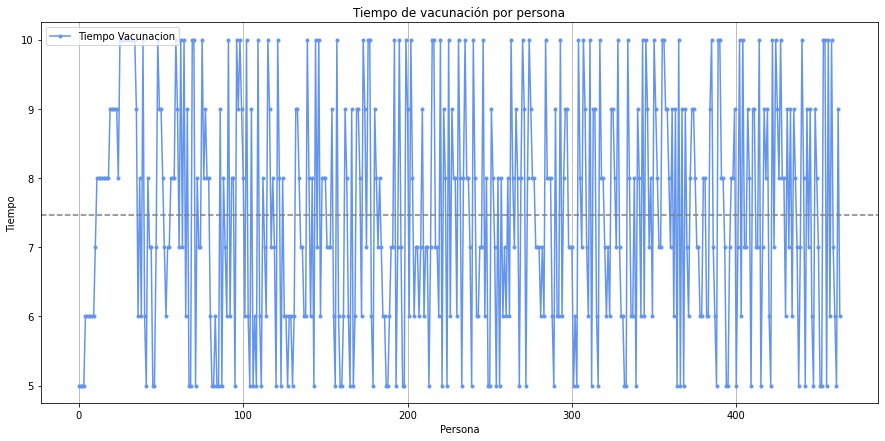

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de vacunación por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOVACUNACIONDICT.keys())
plt.plot(range(len(TIEMPOVACUNACIONDICT1)), TIEMPOVACUNACIONDICT1.values(), '.-', label='Tiempo Vacunacion', color='cornflowerblue')

plt.axhline(y=TIEMPOVACUNACION/CANTIDAD_VACUNADOS, color='gray', linestyle='--')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

### Gráfico: Tiempo de espera total por persona

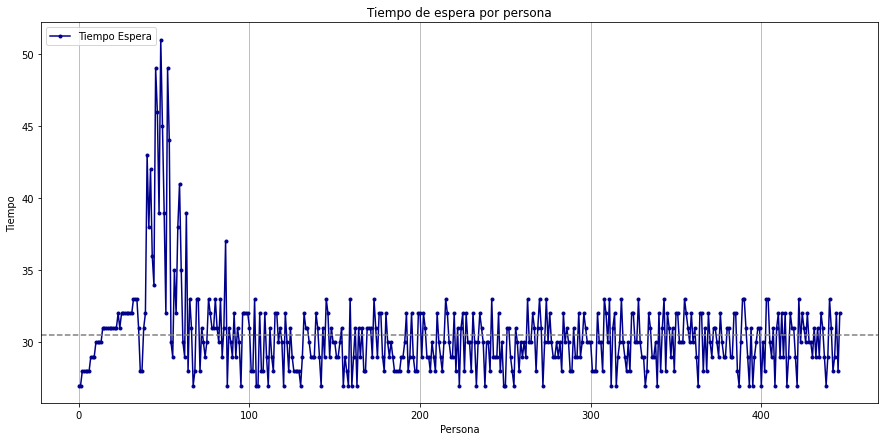

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de espera por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOESPERADICT.keys())
plt.plot(range(len(TIEMPOESPERADICT1)), TIEMPOESPERADICT1.values(), '.-', label='Tiempo Espera', color='darkblue')

plt.axhline(y=TIEMPOESPERA/len(TIEMPOESPERADICT1), color='gray', linestyle='--')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

### Gráfico: Asistente al proceso de vacunación

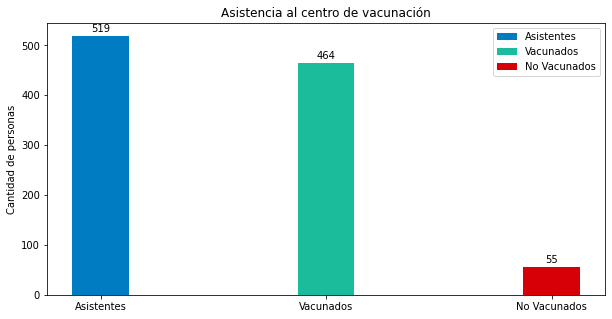

In [95]:
import matplotlib.pyplot as plt

x = [1,2,3]

tags = ['Asistentes','Vacunados', 'No Vacunados']

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x[0], CANTIDAD_PERSONAS, 0.25, label='Asistentes', color="#007CC2")
rects2 = ax.bar(x[1], CANTIDAD_VACUNADOS, 0.25, label='Vacunados', color='#1ABC9C')
rects3= ax.bar(x[2], CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, 0.25, label='No Vacunados', color="#D70006")

labels = [CANTIDAD_PERSONAS,CANTIDAD_VACUNADOS,CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS]

ax.set_ylabel('Cantidad de personas')
ax.set_title('Asistencia al centro de vacunación')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

#### En relación con la cantidad de personas que votan en este recinto, la simulación de 2 horas arroja que: 

In [97]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

print('Se vacunó en 2 horas al:', round(percentage(CANTIDAD_VACUNADOS, 12000),3),'% de todo el recinto electoral')

Se vacunó en 2 horas al: 3.867 % de todo el recinto electoral


#### Esto significa que para alcanzar el 100% de vacunados de ese recinto electoral es necesario:

In [100]:
def percentage(part, whole):
    return (TIEMPO_SIMULACION/60) * float(whole)/float(part)

print('El proceso para la aplicación de la primera dosis tomaría:', round(percentage(CANTIDAD_VACUNADOS, 12000),3),'horas')
print('Trabajando 8 horas diarias el proceso tomaría: ',round(percentage(CANTIDAD_VACUNADOS, 12000)/8), 'días')

El proceso para la aplicación de la primera dosis tomaría: 206.897 horas
Trabajando 8 horas diarias el proceso tomaría:  26 días


## Simulación 30 días despues - Segunda dosis

- En el proceso para la primera dosis los vacunados fueron almacenados en un diccionario, en esta segunda fase de la vacunación estas personas son las primeras en pasar a ser vacunados.

- Si la lista de los vacunados anteriormente termina antes de la simulación, nuevos vacunados ingresarán al proceso y serán registrados dentro del registro de la primera fase.

In [101]:
import numpy as np

#Diccionario a lista
list1 = [(k, v) for k, v in TIEMPOVACUNACIONDICT1.items()]

def ejecutar_simulacion(env, cantMesa, tiempoMesa, tiempoVacunacion, tiempoPostVacunacion):
    vacunacion=Vacunacion(env, cantMesa, tiempoMesa, tiempoVacunacion, tiempoPostVacunacion)
    
    # Creamos 40 persona que llegan a la segunda dosis
    for i in range(40):
        conteoPersonas()
        env.process(llegada_persona(env, 'Persona-%d'%(list1[i][0]), vacunacion, 2))
   
    idPersona=cantMesa
    max_key = max(TIEMPOVACUNACIONDICT1)
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(1)
        if(idPersona<len(list1)):
            conteoPersonas()
            env.process(llegada_persona(env,'Persona-%d'%(list1[idPersona][0]), vacunacion, 2))  
            idPersona+=1
        else:
            conteoPersonas()
            max_key+=1
            env.process(llegada_persona(env,'Persona-%d'%(max_key), vacunacion, 1))  
            

env=simpy.Environment()
env.process(ejecutar_simulacion(env, MESAS, INTERVALO_MESA, INTERVALO_VACUNACION, INTERVALO_POST_VACUNACION))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

→ [Persona-28] llega al recinto a la hora 0.00.
→ [Persona-34] llega al recinto a la hora 0.00.
→ [Persona-36] llega al recinto a la hora 0.00.
→ [Persona-37] llega al recinto a la hora 0.00.
→ [Persona-2] llega al recinto a la hora 0.00.
→ [Persona-4] llega al recinto a la hora 0.00.
→ [Persona-7] llega al recinto a la hora 0.00.
→ [Persona-14] llega al recinto a la hora 0.00.
→ [Persona-26] llega al recinto a la hora 0.00.
→ [Persona-30] llega al recinto a la hora 0.00.
→ [Persona-23] llega al recinto a la hora 0.00.
→ [Persona-5] llega al recinto a la hora 0.00.
→ [Persona-6] llega al recinto a la hora 0.00.
→ [Persona-8] llega al recinto a la hora 0.00.
→ [Persona-16] llega al recinto a la hora 0.00.
→ [Persona-20] llega al recinto a la hora 0.00.
→ [Persona-24] llega al recinto a la hora 0.00.
→ [Persona-29] llega al recinto a la hora 0.00.
→ [Persona-40] llega al recinto a la hora 0.00.
→ [Persona-9] llega al recinto a la hora 0.00.
→ [Persona-18] llega al recinto a la hora 0.00.

La [Persona-326] fue vacunada a las 263.00.
La [Persona-326] pasa al control post-vacuna a las 263.00.
← La persona [Persona-298] sale del centro a las 263.00.
← La persona [Persona-301] sale del centro a las 263.00.
← La persona [Persona-300] sale del centro a las 263.00.
La [Persona-334] pasa a la silla de vacunación a la hora 263.00.
→ [Persona-336] llega al recinto a la hora 264.00.
La [Persona-303] pasa a recibir su certificado a las 264.00.
La [Persona-304] pasa a recibir su certificado a las 264.00.
La [Persona-306] pasa a recibir su certificado a las 264.00.
La [Persona-335] pasa a la silla de vacunación a la hora 264.00.
→ [Persona-333] llega al recinto a la hora 265.00.
La [Persona-308] pasa a recibir su certificado a las 265.00.
La [Persona-325] fue vacunada a las 265.00.
La [Persona-325] pasa al control post-vacuna a las 265.00.
La [Persona-330] fue vacunada a las 265.00.
La [Persona-330] pasa al control post-vacuna a las 265.00.
← La persona [Persona-299] sale del centro a

### Métricas

In [102]:
print('Total de Personas:', CANTIDAD_PERSONAS, '\n')
print('Total Vacunados:', CANTIDAD_VACUNADOS, '\n')
print('Total No Vacunados:', CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, '\n')
print('Tiempo de vacunación promedio: ', round(TIEMPOVACUNACION/CANTIDAD_VACUNADOS, 2), '\n')
print('Tiempo de espera promedio: ', round(TIEMPOESPERA/(len(TIEMPOESPERADICT1)+len(TIEMPOESPERADICT2)), 2), '\n')
print('Tiempo total de vacunación: ', TIEMPOVACUNACION, '\n')

Total de Personas: 1038 

Total Vacunados: 941 

Total No Vacunados: 97 

Tiempo de vacunación promedio:  7.48 

Tiempo de espera promedio:  30.57 

Tiempo total de vacunación:  7037 



### Gráfico del tiempo de vacunación de cada persona.

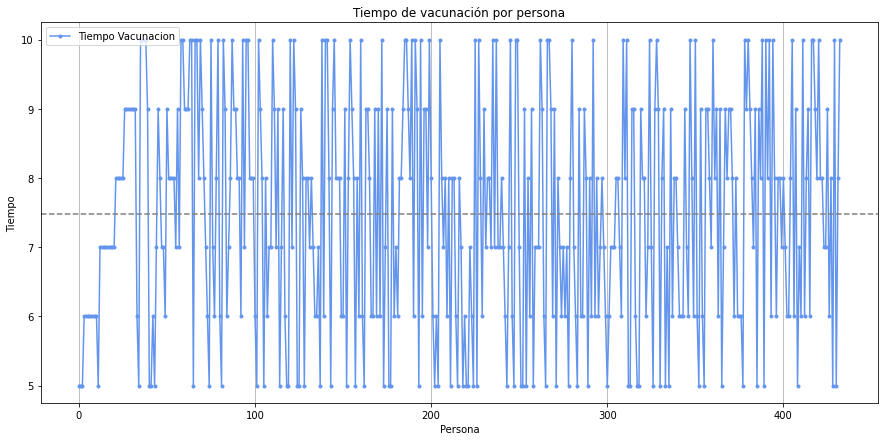

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de vacunación por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOVACUNACIONDICT.keys())
plt.plot(range(len(TIEMPOVACUNACIONDICT2)), TIEMPOVACUNACIONDICT2.values(), '.-', label='Tiempo Vacunacion', color='cornflowerblue')

plt.axhline(y=TIEMPOVACUNACION/CANTIDAD_VACUNADOS, color='gray', linestyle='--')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

### Gráfico del tiempo de espera por cada persona.

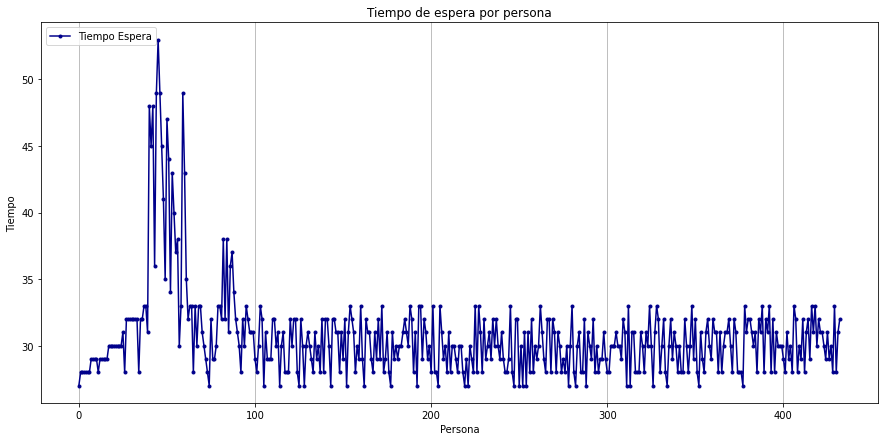

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

plt.title("Tiempo de espera por persona")
plt.xlabel("Persona")
plt.ylabel("Tiempo")

#list(TIEMPOESPERADICT.keys())
plt.plot(range(len(TIEMPOESPERADICT2)), TIEMPOESPERADICT2.values(), '.-', label='Tiempo Espera', color='darkblue')

plt.grid(axis='x')

plt.legend(loc="upper left")

plt.show()

### Gráfico del total de personas vacunadas con la primera y segunda dosis.

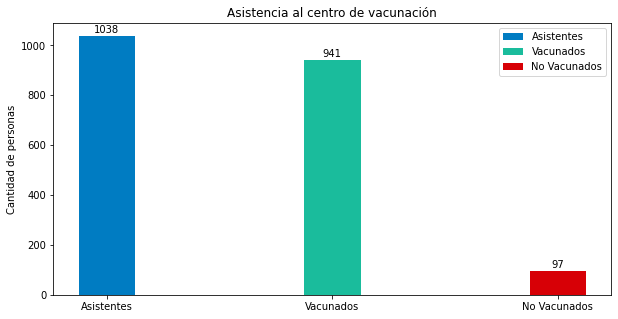

In [105]:
import matplotlib.pyplot as plt

x = [1,2,3]

tags = ['Asistentes','Vacunados', 'No Vacunados']

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x[0], CANTIDAD_PERSONAS, 0.25, label='Asistentes', color="#007CC2")
rects2 = ax.bar(x[1], CANTIDAD_VACUNADOS, 0.25, label='Vacunados', color='#1ABC9C')
rects3= ax.bar(x[2], CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS, 0.25, label='No Vacunados', color="#D70006")

rects = ax.patches

labels = [CANTIDAD_PERSONAS,CANTIDAD_VACUNADOS,CANTIDAD_PERSONAS-CANTIDAD_VACUNADOS]

ax.set_ylabel('Cantidad de personas')
ax.set_title('Asistencia al centro de vacunación')
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend(loc="upper right")

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()